In [9]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in Drive
src = "/content/drive/My Drive/UnorganizedDataset"
dest = "/content/UnorganizedDataset"

import shutil
# Copy the dataset to Colab's environment
shutil.copytree(src, dest)
print(f"Dataset copied to: {dest}")

Mounted at /content/drive
Dataset copied to: /content/UnorganizedDataset


In [10]:
!pip install timm

In [11]:
# Import necessary libraries
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_dir = "/content/UnorganizedDataset"  # Path to your current dataset
organized_dir = "/content/OrganizedDataset"  # Path to save the organized dataset

# Create directories for Train, Validation, and Test
os.makedirs(os.path.join(organized_dir, "Train"), exist_ok=True)
os.makedirs(os.path.join(organized_dir, "Validation"), exist_ok=True)
os.makedirs(os.path.join(organized_dir, "Test"), exist_ok=True)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Organize the dataset into Train, Validation, and Test
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)

        # Split the data into Train, Validation, and Test
        train, temp = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

        # Create subdirectories for each class in Train, Validation, and Test
        os.makedirs(os.path.join(organized_dir, "Train", class_name), exist_ok=True)
        os.makedirs(os.path.join(organized_dir, "Validation", class_name), exist_ok=True)
        os.makedirs(os.path.join(organized_dir, "Test", class_name), exist_ok=True)

        # Copy the images to their respective folders
        for img in train:
            shutil.copy(os.path.join(class_dir, img), os.path.join(organized_dir, "Train", class_name))
        for img in val:
            shutil.copy(os.path.join(class_dir, img), os.path.join(organized_dir, "Validation", class_name))
        for img in test:
            shutil.copy(os.path.join(class_dir, img), os.path.join(organized_dir, "Test", class_name))

print("Dataset successfully organized into Train, Validation, and Test!")

Dataset successfully organized into Train, Validation, and Test!


In [12]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Path to the organized dataset
dataset_dir = "/content/OrganizedDataset"

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally
    transforms.RandomRotation(10),            # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load datasets using ImageFolder
train_data = datasets.ImageFolder(os.path.join(dataset_dir, 'Train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(dataset_dir, 'Validation'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(dataset_dir, 'Test'), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # Batch size of 32
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Display dataset sizes
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

# Display class names
print(f"Class names: {train_data.classes}")

Train dataset size: 2712
Validation dataset size: 582
Test dataset size: 584
Class names: ['Mature', 'NonCoconut', 'Old', 'Young']


In [13]:
# Import necessary libraries
import torch
import torch.nn as nn
from timm import create_model

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model
model = create_model('efficientnet_b1', pretrained=True)  # Use pretrained EfficientNet B1
model.classifier = nn.Linear(model.classifier.in_features, len(train_data.classes))  # Adjust for your number of classes
model = model.to(device)

# Define the loss function (cross-entropy loss for classification tasks)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Model, Loss, and Optimizer are set up!")

Using device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

Model, Loss, and Optimizer are set up!


In [14]:
# Import necessary libraries
import torch
from tqdm import tqdm  # For showing progress bars during training

# Define training parameters
num_epochs = 10  # Adjust the number of epochs as needed
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Path to save the model
model_save_path = "/content/drive/My Drive/EfficientNetB1_model.pth"

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training phase
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save the model at each epoch to avoid losing progress
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path} after epoch {epoch+1}")

print("Training completed!")

# Final saving of the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Final model saved to {model_save_path}")

# Optional: Notify when training is completed
from google.colab import output
output.eval_js('new Notification("Training Completed! 🎉")')

Epoch 1/10 [Validation]: 100%|██████████| 19/19 [00:58<00:00,  3.05s/it]


Epoch [1/10] - Train Loss: 0.4106, Train Acc: 86.39%, Val Loss: 42621.3689, Val Acc: 89.86%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 1


Epoch 2/10 [Validation]: 100%|██████████| 19/19 [00:55<00:00,  2.95s/it]


Epoch [2/10] - Train Loss: 0.1787, Train Acc: 94.14%, Val Loss: 0.2136, Val Acc: 94.67%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 2


Epoch 3/10 [Validation]: 100%|██████████| 19/19 [00:58<00:00,  3.08s/it]


Epoch [3/10] - Train Loss: 0.1811, Train Acc: 93.69%, Val Loss: 77.9586, Val Acc: 67.18%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 3


Epoch 4/10 [Validation]: 100%|██████████| 19/19 [00:56<00:00,  2.99s/it]


Epoch [4/10] - Train Loss: 0.1988, Train Acc: 94.21%, Val Loss: 530.9830, Val Acc: 96.91%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 4


Epoch 5/10 [Validation]: 100%|██████████| 19/19 [00:57<00:00,  3.01s/it]


Epoch [5/10] - Train Loss: 0.1192, Train Acc: 95.87%, Val Loss: 0.0980, Val Acc: 96.39%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 5


Epoch 6/10 [Validation]: 100%|██████████| 19/19 [00:58<00:00,  3.06s/it]


Epoch [6/10] - Train Loss: 0.0800, Train Acc: 97.68%, Val Loss: 0.2325, Val Acc: 93.13%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 6


Epoch 7/10 [Validation]: 100%|██████████| 19/19 [00:57<00:00,  3.04s/it]


Epoch [7/10] - Train Loss: 0.0880, Train Acc: 96.53%, Val Loss: 0.0393, Val Acc: 98.63%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 7


Epoch 8/10 [Validation]: 100%|██████████| 19/19 [00:58<00:00,  3.07s/it]


Epoch [8/10] - Train Loss: 0.0702, Train Acc: 97.49%, Val Loss: 86.7369, Val Acc: 96.74%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 8


Epoch 9/10 [Validation]: 100%|██████████| 19/19 [00:59<00:00,  3.14s/it]


Epoch [9/10] - Train Loss: 0.1042, Train Acc: 96.64%, Val Loss: 0.0754, Val Acc: 98.11%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 9


Epoch 10/10 [Validation]: 100%|██████████| 19/19 [00:56<00:00,  2.96s/it]


Epoch [10/10] - Train Loss: 0.0758, Train Acc: 97.53%, Val Loss: 0.2481, Val Acc: 98.45%
Model saved to /content/drive/My Drive/EfficientNetB1_model.pth after epoch 10
Training completed!
Final model saved to /content/drive/My Drive/EfficientNetB1_model.pth


MessageError: DataCloneError: The object can not be cloned.

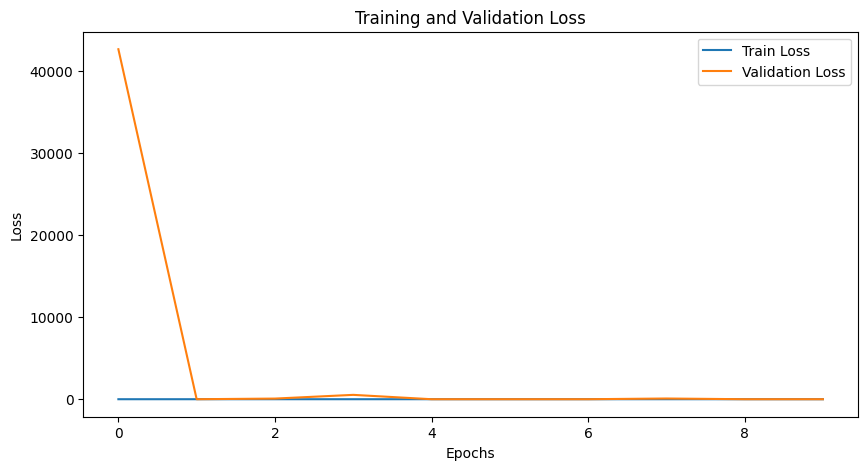

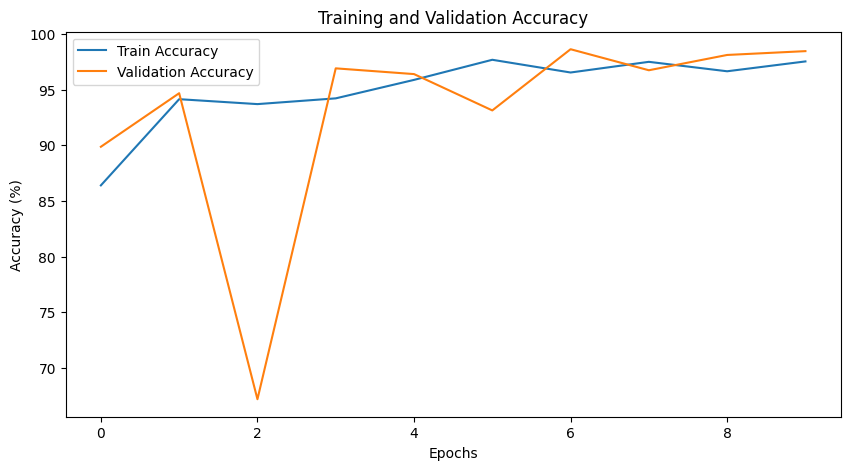

In [15]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

Evaluating on Test Set: 100%|██████████| 19/19 [00:57<00:00,  3.04s/it]


Test Accuracy: 98.63%


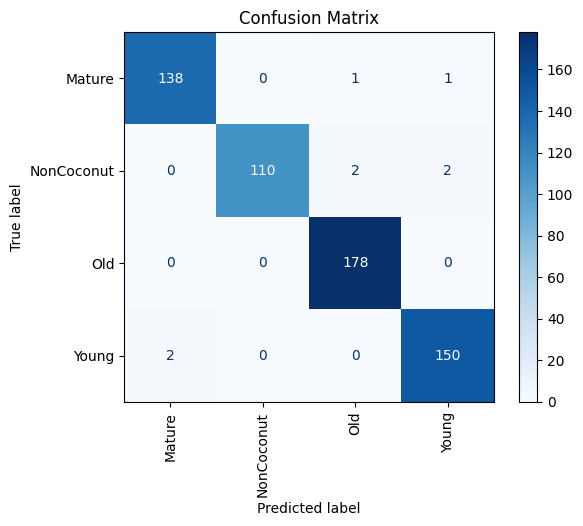

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluate on the test set
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(train_data.classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

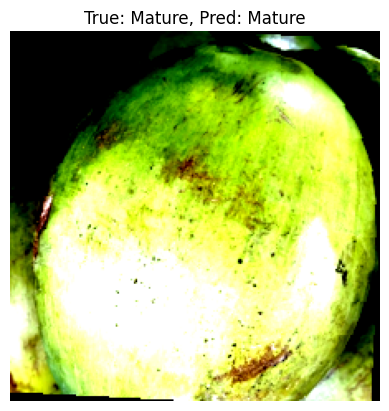

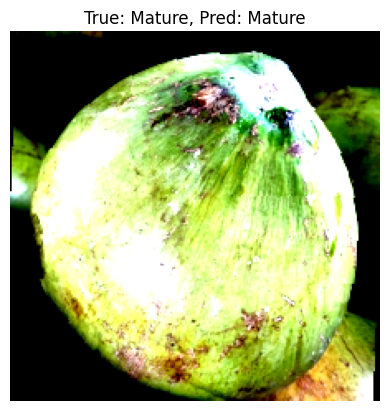

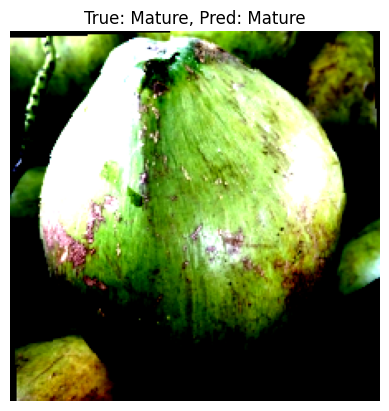

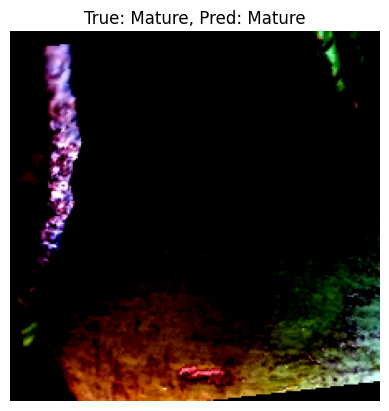

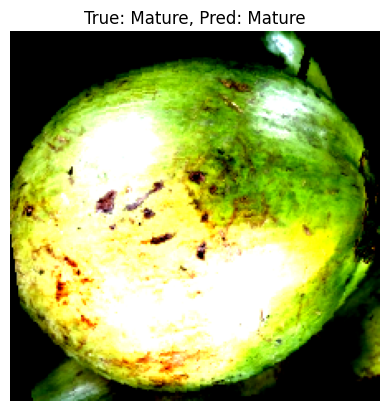

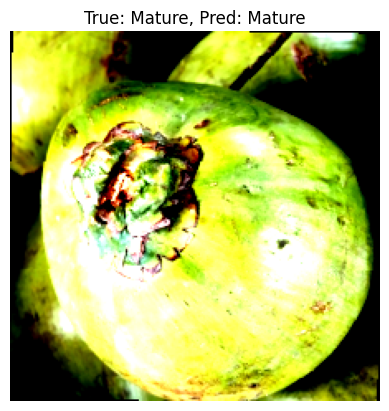

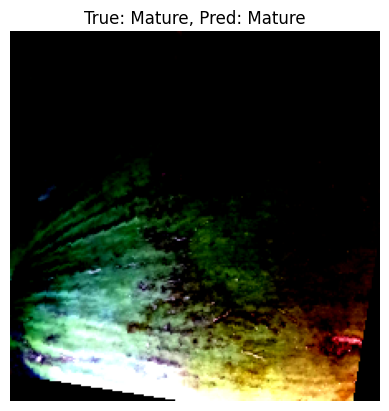

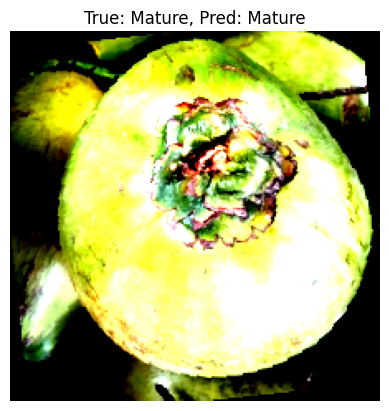

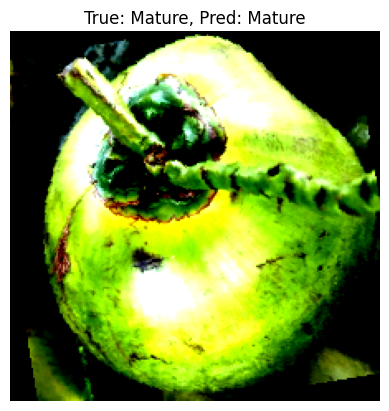

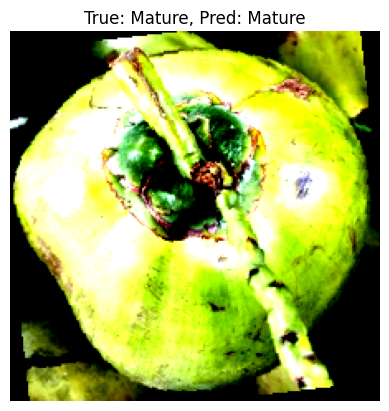

In [17]:
# Display predictions on a few test images
import torchvision.transforms.functional as F

# Unnormalize and display images
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(min(10, inputs.size(0))):  # Display up to 10 images
            img = F.to_pil_image(inputs[i].cpu().clamp(0, 1))  # Convert to PIL image
            plt.imshow(img)
            plt.title(f"True: {train_data.classes[labels[i]]}, Pred: {train_data.classes[preds[i]]}")
            plt.axis("off")
            plt.show()
        break